# Продвинутые Свёрточные Нейронные Сети.
# Домашняя работа
# Transfer Learning

Обучить СНС с помощью Transfer Learning на датасете Food-101
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.

# 1. Подключение библиотек

In [1]:
%tensorflow_version 2.x

In [2]:
%matplotlib inline
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.image as img
from collections import defaultdict
import collections
import os

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5067739934246709591, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8782979514596250924
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9233268698046642782
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150603072
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15684430643097694582
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

# 2. Загрузка и подготовка датасета Food-101

Часть кода взята отсюда https://colab.research.google.com/drive/1Z5-LqlJxNslHcCzM9jChsNhGi9Y7HSC4#scrollTo=JBs1U7hZkp1U

## 2.1. Загрузка датасета

In [4]:
# Helper function to download data and extract
import os
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [5]:
# Download data and extract it to folder
get_data_extract()

Выходные данные были обрезаны до нескольких последних строк (5000).
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/3452001.jpg
food-10

In [6]:
# Check the extracted dataset folder
!ls food-101/

images	license_agreement.txt  meta  README.txt


In [7]:
os.listdir('food-101/images')

['hummus',
 'ceviche',
 'chicken_quesadilla',
 'clam_chowder',
 'garlic_bread',
 'escargots',
 'beef_tartare',
 'strawberry_shortcake',
 'hot_dog',
 'prime_rib',
 'lobster_bisque',
 'steak',
 'gnocchi',
 'french_toast',
 'dumplings',
 'peking_duck',
 'paella',
 'macaroni_and_cheese',
 'mussels',
 'takoyaki',
 'club_sandwich',
 'cheese_plate',
 'guacamole',
 'falafel',
 'apple_pie',
 'oysters',
 'chocolate_mousse',
 'seaweed_salad',
 'samosa',
 'baklava',
 'pizza',
 'grilled_salmon',
 'spaghetti_carbonara',
 'pad_thai',
 'onion_rings',
 'beet_salad',
 'poutine',
 'cheesecake',
 'frozen_yogurt',
 'filet_mignon',
 'bibimbap',
 'bruschetta',
 'chicken_curry',
 'sashimi',
 'spaghetti_bolognese',
 'hot_and_sour_soup',
 'risotto',
 'scallops',
 'beef_carpaccio',
 'cup_cakes',
 'croque_madame',
 'caprese_salad',
 'gyoza',
 'sushi',
 'tuna_tartare',
 'french_fries',
 'caesar_salad',
 'chicken_wings',
 'foie_gras',
 'carrot_cake',
 'edamame',
 'macarons',
 'churros',
 'deviled_eggs',
 'shrimp_an

In [8]:
os.listdir("/content/")

['.config', 'food-101.tar.gz', 'food-101', 'sample_data']

In [9]:
os.listdir('food-101/meta')

['test.json',
 'classes.txt',
 'test.txt',
 'labels.txt',
 'train.json',
 'train.txt']

In [10]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [11]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


In [12]:
!ls

food-101  food-101.tar.gz  sample_data


In [13]:
# Удаление архива
!rm -r food-101.tar.gz

In [14]:
!ls

food-101  sample_data


## 2.2. Визуализация картинок

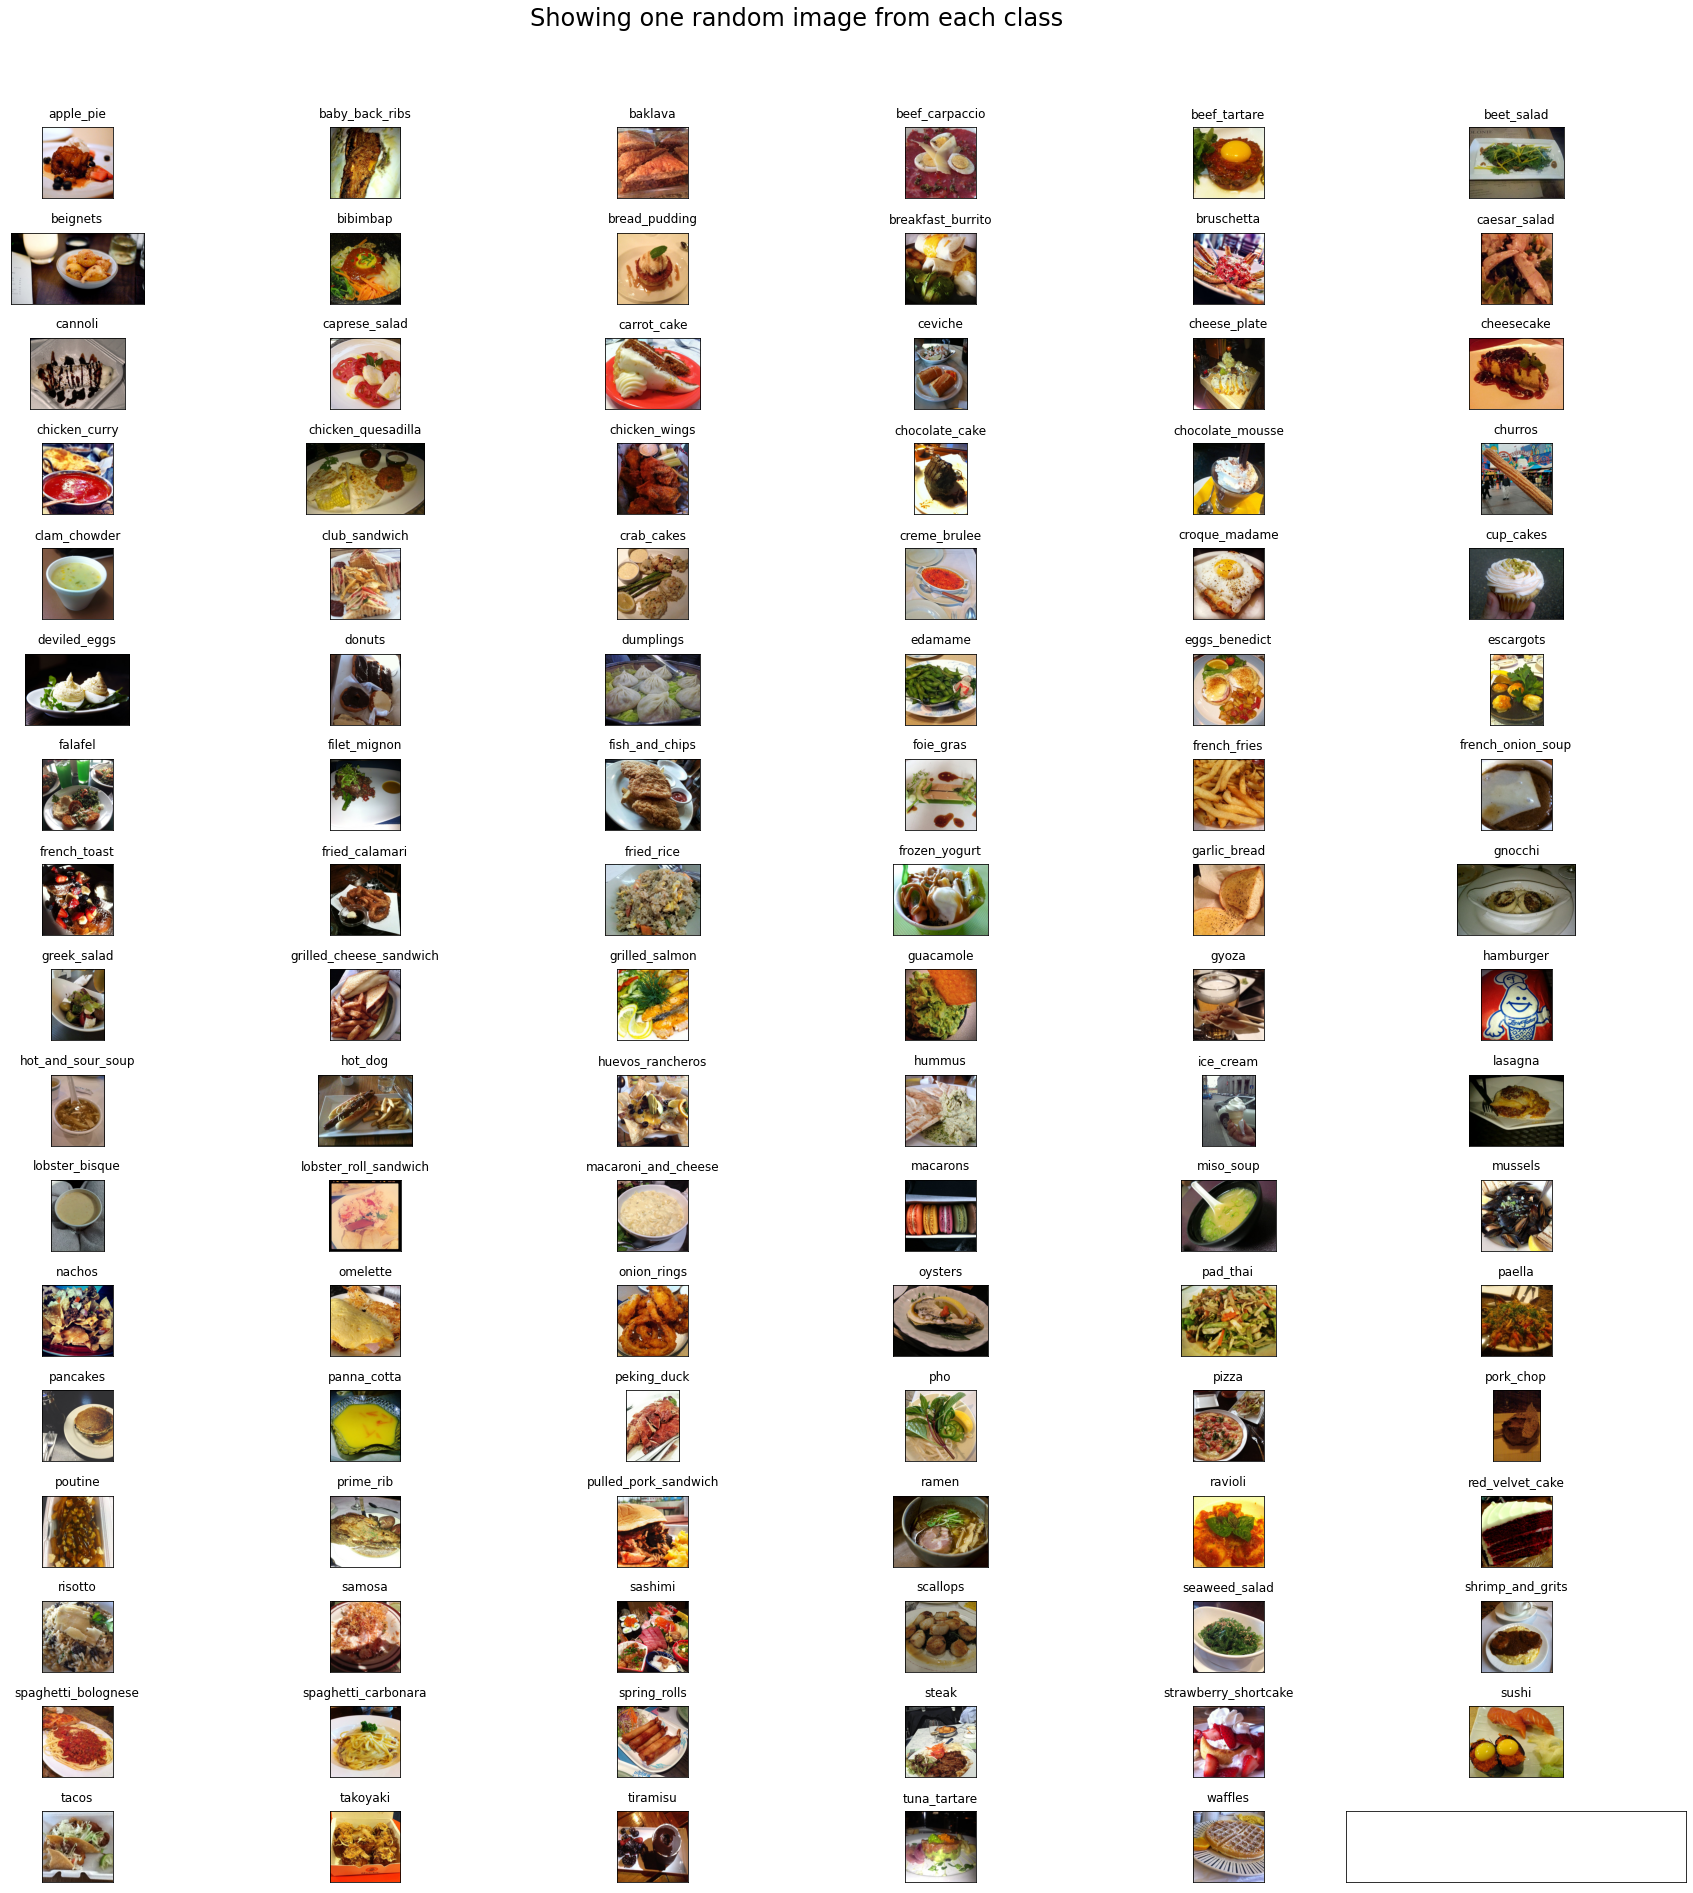

In [15]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html

## 2.3. Разделение на train и test

In [16]:
# Helper method to split dataset into train and test folders
from shutil import copy
def prepare_data(filepath, src, dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [17]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [18]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [19]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find food-101/train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [20]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find food-101/test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [21]:
!ls

food-101  sample_data


In [22]:
os.listdir('food-101')

['images', 'README.txt', 'test', 'license_agreement.txt', 'meta', 'train']

In [23]:
os.chdir('food-101')

In [24]:
!ls

images	license_agreement.txt  meta  README.txt  test  train


In [25]:
rm -r images

In [26]:
!ls

license_agreement.txt  meta  README.txt  test  train


In [27]:
os.listdir('/content/food-101/train/samosa/')

['3550177.jpg',
 '1911764.jpg',
 '950521.jpg',
 '1182602.jpg',
 '1917898.jpg',
 '3921988.jpg',
 '1982708.jpg',
 '1872099.jpg',
 '3307276.jpg',
 '1478597.jpg',
 '3686755.jpg',
 '382964.jpg',
 '320831.jpg',
 '575740.jpg',
 '228937.jpg',
 '1564429.jpg',
 '1248490.jpg',
 '1832423.jpg',
 '2740547.jpg',
 '793375.jpg',
 '2856612.jpg',
 '50168.jpg',
 '2579466.jpg',
 '3768255.jpg',
 '2072483.jpg',
 '2168816.jpg',
 '1976281.jpg',
 '1598130.jpg',
 '1145678.jpg',
 '2591759.jpg',
 '1173240.jpg',
 '1441481.jpg',
 '2427760.jpg',
 '395816.jpg',
 '1011601.jpg',
 '732857.jpg',
 '2049286.jpg',
 '2716223.jpg',
 '925427.jpg',
 '2728267.jpg',
 '2549025.jpg',
 '3017573.jpg',
 '2268066.jpg',
 '3470860.jpg',
 '1968785.jpg',
 '2936812.jpg',
 '1164731.jpg',
 '2318258.jpg',
 '3660374.jpg',
 '966658.jpg',
 '2587215.jpg',
 '183333.jpg',
 '2540377.jpg',
 '3625442.jpg',
 '1304601.jpg',
 '1867571.jpg',
 '1608773.jpg',
 '1420619.jpg',
 '2122197.jpg',
 '1075307.jpg',
 '816846.jpg',
 '3519574.jpg',
 '463535.jpg',
 '38057

## 2.4. Создание мини датасетов

### Весь датасет большой, и проведение экспериментов с архитектурой модели на нем дорог по времени. Поэтому создадим мини датасет из 3-х классов вместо 101. Подберем наилучшие гиперпараметры и структуру сети, а потом обучим сеть на всем датасете.

In [28]:
# Helper method to create train_mini and test_mini data samples
from shutil import copytree, rmtree
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [29]:
# picking 3 food items and generating separate data folders for the same
food_list = ['samosa','pizza','omelette']
src_train = '/content/food-101/train'
dest_train = '/content/food-101/train_mini'
src_test = '/content/food-101/test'
dest_test = '/content/food-101/test_mini'

In [30]:
!ls

license_agreement.txt  meta  README.txt  test  train


In [31]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [32]:
print("Total number of samples in train folder")

!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
2250


In [33]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [34]:
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
750


In [35]:
os.listdir('/content/food-101/')

['test_mini',
 'README.txt',
 'test',
 'train_mini',
 'license_agreement.txt',
 'meta',
 'train']

# 3. Обучение модели на мини датасете

## 3.1. Transfer learning

In [36]:
EXP_NAME = 'mini'

In [37]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+EXP_NAME, 
    write_graph=False, update_freq=100, profile_batch=0)

In [38]:
! pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-ocl_gw6w
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-ocl_gw6w
  Created wheel for efficientnet: filename=efficientnet-1.1.0-cp36-none-any.whl size=18398 sha256=e661f1d9e5eb47257f61e4b3f9628f006b3f38658c5dbd29703f411eb6243dcb
  Stored in directory: /tmp/pip-ephem-wheel-cache-hjixy5br/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


In [39]:
import efficientnet.tfkeras as efn

In [40]:
K.clear_session()

n_classes = 3
img_width, img_height = 256, 256
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16
initial_epochs = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

base_model = efn.EfficientNetB4(weights='imagenet', input_shape=[256, 256, 3], include_top=False)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)
#optimizer = SGD(lr=0.0001, momentum=0.9)
optimizer = Adam(lr=0.0001)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
71892992/71892840 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 1

In [41]:
history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=initial_epochs,
                    verbose=1,
                    callbacks=[tensorboard_callback])

model.save('model_trained_3class.hdf5')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
140/140 [==============================] - 64s 455ms/step - loss: 0.7189 - accuracy: 0.7386 - val_loss: 0.3809 - val_accuracy: 0.8818
Epoch 2/10
140/140 [==============================] - 60s 431ms/step - loss: 0.4426 - accuracy: 0.8465 - val_loss: 0.3108 - val_accuracy: 0.8927
Epoch 3/10
140/140 [==============================] - 60s 429ms/step - loss: 0.3884 - accuracy: 0.8639 - val_loss: 0.2771 - val_accuracy: 0.9144
Epoch 4/10
140/140 [==============================] - 60s 425ms/step - loss: 0.3596 - accuracy: 0.8765 - val_loss: 0.2648 - val_accuracy: 0.9144
Epoch 5/10
140/140 [==============================] - 59s 424ms/step - loss: 0.3449 - accuracy: 0.8778 - val_loss: 0.2543 - val_accuracy: 0.9130
Epoch 6/10
140/140 [==============================] - 60s 427ms/step - loss: 0.3254 - accuracy: 0.8912 - val_loss: 0.2469 - val_accuracy: 0.9226
Epoch 7/10
140/140 [==============================] - 

In [42]:
%%time

model.evaluate(validation_generator)

47/47 [==============================] - 10s 212ms/step - loss: 0.2378 - accuracy: 0.9213
CPU times: user 7.84 s, sys: 853 ms, total: 8.7 s
Wall time: 10.4 s


[0.23782484233379364, 0.9213333129882812]

## 3.2. Fine-tuning

In [43]:
base_model.trainable = True

In [44]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 400

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  467


In [45]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 48) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [46]:
len(model.trainable_variables)

64

In [47]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs


history_fine = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=total_epochs,
                    initial_epoch =  history.epoch[-1],
                    verbose=1,
                    callbacks=[tensorboard_callback])

Epoch 10/20
140/140 [==============================] - 65s 465ms/step - loss: 0.4285 - accuracy: 0.8487 - val_loss: 0.1992 - val_accuracy: 0.9375
Epoch 11/20
140/140 [==============================] - 62s 446ms/step - loss: 0.2140 - accuracy: 0.9315 - val_loss: 0.1577 - val_accuracy: 0.9511
Epoch 12/20
140/140 [==============================] - 63s 447ms/step - loss: 0.1873 - accuracy: 0.9449 - val_loss: 0.1508 - val_accuracy: 0.9579
Epoch 13/20
140/140 [==============================] - 62s 443ms/step - loss: 0.1455 - accuracy: 0.9606 - val_loss: 0.1620 - val_accuracy: 0.9511
Epoch 14/20
140/140 [==============================] - 62s 444ms/step - loss: 0.1272 - accuracy: 0.9646 - val_loss: 0.1520 - val_accuracy: 0.9606
Epoch 15/20
140/140 [==============================] - 62s 440ms/step - loss: 0.1173 - accuracy: 0.9687 - val_loss: 0.1376 - val_accuracy: 0.9511
Epoch 16/20
140/140 [==============================] - 62s 442ms/step - loss: 0.1149 - accuracy: 0.9718 - val_loss: 0.1519 -

In [48]:
%%time

model.evaluate(validation_generator)

47/47 [==============================] - 9s 196ms/step - loss: 0.1379 - accuracy: 0.9667
CPU times: user 7.23 s, sys: 517 ms, total: 7.74 s
Wall time: 9.63 s


[0.13790100812911987, 0.9666666388511658]

# 4. Обучение модели на полном датасете

## 4.1. Transfer learning

In [49]:
!ls

license_agreement.txt  model_trained_3class.hdf5  test_mini
logs		       README.txt		  train
meta		       test			  train_mini


In [50]:
EXP_NAME = 'full'

In [51]:
K.clear_session()

n_classes = 101
img_width, img_height = 256, 256
train_data_dir = 'train'
validation_data_dir = 'test'
nb_train_samples = 75750
nb_validation_samples = 25250
batch_size = 16
initial_epochs = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

base_model = efn.EfficientNetB4(weights='imagenet', input_shape=[256, 256, 3], include_top=False)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(101, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)
#optimizer = SGD(lr=0.0001, momentum=0.9)
optimizer = Adam(lr=0.0001)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 48) 0           stem_bn[0][0]                    
____

In [52]:
history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=initial_epochs,
                    verbose=1,
                    callbacks=[tensorboard_callback])

model.save('model_trained_101class.hdf5')

Epoch 1/10
4734/4734 [==============================] - 2071s 437ms/step - loss: 3.7911 - accuracy: 0.2303 - val_loss: 2.6815 - val_accuracy: 0.4594
Epoch 2/10
4734/4734 [==============================] - 2023s 427ms/step - loss: 3.0058 - accuracy: 0.3531 - val_loss: 2.3390 - val_accuracy: 0.5080
Epoch 3/10
4734/4734 [==============================] - 1955s 413ms/step - loss: 2.7847 - accuracy: 0.3919 - val_loss: 2.1610 - val_accuracy: 0.5419
Epoch 4/10
4734/4734 [==============================] - 1935s 409ms/step - loss: 2.6482 - accuracy: 0.4142 - val_loss: 2.0577 - val_accuracy: 0.5564
Epoch 5/10
4734/4734 [==============================] - 1939s 410ms/step - loss: 2.5528 - accuracy: 0.4290 - val_loss: 1.9776 - val_accuracy: 0.5663
Epoch 6/10
4734/4734 [==============================] - 1945s 411ms/step - loss: 2.4848 - accuracy: 0.4405 - val_loss: 1.9179 - val_accuracy: 0.5749
Epoch 7/10
4734/4734 [==============================] - 1925s 407ms/step - loss: 2.4365 - accuracy: 0.4475

In [53]:
%%time

model.evaluate(validation_generator)

1579/1579 [==============================] - 317s 201ms/step - loss: 1.7839 - accuracy: 0.5960
CPU times: user 4min 9s, sys: 16.8 s, total: 4min 26s
Wall time: 5min 17s


[1.7839359045028687, 0.5960000157356262]

## 4.2. Fine-tuning

In [54]:
base_model.trainable = True

In [55]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 400

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  467


In [56]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 48) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs


history_fine = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=total_epochs,
                    initial_epoch =  history.epoch[-1],
                    verbose=1,
                    callbacks=[tensorboard_callback])

Epoch 10/20
4734/4734 [==============================] - 2152s 455ms/step - loss: 2.0993 - accuracy: 0.5124 - val_loss: 1.2402 - val_accuracy: 0.7084
Epoch 11/20
4734/4734 [==============================] - 2155s 455ms/step - loss: 1.7291 - accuracy: 0.5941 - val_loss: 1.0893 - val_accuracy: 0.7412
Epoch 12/20
4734/4734 [==============================] - 2147s 453ms/step - loss: 1.5448 - accuracy: 0.6349 - val_loss: 1.0204 - val_accuracy: 0.7558
Epoch 13/20
4734/4734 [==============================] - 2147s 453ms/step - loss: 1.4071 - accuracy: 0.6634 - val_loss: 0.9743 - val_accuracy: 0.7645
Epoch 14/20
4734/4734 [==============================] - 2136s 451ms/step - loss: 1.2978 - accuracy: 0.6876 - val_loss: 0.9419 - val_accuracy: 0.7730
Epoch 15/20
4734/4734 [==============================] - 2138s 452ms/step - loss: 1.2062 - accuracy: 0.7061 - val_loss: 0.9165 - val_accuracy: 0.7793
Epoch 16/20
2796/4734 [================>.............] - ETA: 12:30 - loss: 1.1144 - accuracy: 0.726

In [ ]:
%%time

model.evaluate(validation_generator)

# 5. Визуализация через TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs